In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import cm # color stuff
from scipy.optimize import curve_fit
import itertools
plotmarkers=['^-', 'o-', 's-', '*-', 'd-', 'v-', 'h-', '>-', 'D-', 'H-', '<-', 'o-', 's-', '3-']
from scipy.optimize import curve_fit
import csv
%matplotlib inline


def pltDefaultPar():
    #reset default matplotlib parameters for this notebook
    plt.rcParams.update({'font.size': 20})
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 6
    
def pltPrintPar():
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 8

figsizeRanb=(5, 3.5)#(6,4) is default size in inches
plt.rcParams.update({'font.size': 11}) #default is 10

from matplotlib.ticker import AutoMinorLocator  #Stuff for ticks
minorLocator = AutoMinorLocator(2)

    
rootTP="/home/johann/Remote/imac"
rootTP2="/home/johann/Remote2"
rootMAC="/Users/jh"
root=rootMAC



#### Latex stuff
\newcommand{\sd}{\sigma_d}: $\newcommand{\sd}{\sigma_d}$
test if this works $\sd$ 

In [2]:
def stexp(x,a,n):
    return np.exp(-a*x**n)

### Comparison of phi(a) formulas

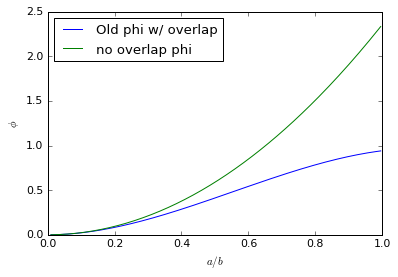

In [3]:
# Function to plot D over phi vary lub noLub data with fixed aop
Vcyl = lambda a, b: np.pi*b*(a/2.)**2
def phiOverlap(aob): # Old formula for phi for overlapping cylinders
    return (3*Vcyl(aob,b=1) - 8 * np.sqrt(2) * (aob/2.)**3)

def phiNoOverlap(aob): 
    return 3*Vcyl(aob,b=1) # This is almost the same formula as for the old model, but without the overlap term

def ptoPhiOverlap(prel,aop):
    return phiOverlap(prel*aop)

arels=np.arange(0.01,1,0.005)
plt.plot(arels,phiOverlap(arels),label='Old phi w/ overlap')
plt.plot(arels,phiNoOverlap(arels),label='no overlap phi')
plt.xlabel(r'$a/b$')
plt.ylabel(r'$\phi$')
plt.legend(loc=0)
plt.show()

#### Conclusion:
The difference between the two formulas for phi become truly substantial for $a>0.4b$ (or equivalently phi>0.25). If i **stick with aop<=0.5 like for HIforBD**, then the maximal value for $a$ is $a_{max}=0.33b$, which would be fine. Furthermore, the new phi formula without overlap becomes too large, i.e. larger than one for $a\approx0.7$.
**NOTE:** It might be better to **use the old version for phi** with overlap, since in the limit of large $a/b\approx1$ the cylinders *will* overlap for sure.

In [9]:
def plotdataArr(dataArray,xlabel,lineArr,lineParam='',linestyles='',setlog='',legendloc=0,noshow=False,tofile=False,filename=''):
    # color stuff: http://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
    colors=cm.rainbow(np.linspace(0,1,len(dataArray)))
    if linestyles=='': lslist = len(dataArray) * ['o-']
    else: lslist = linestyles
    plt.figure()
    for i, line in enumerate(dataArray):
        ti = lineParam + str(lineArr[i])
        xs = line[:,0]
        dd0s = line[:,1]/6.
        plt.plot(xs,dd0s,lslist[i],label=ti,c=colors[i])
    plt.xlabel(r'$'+xlabel+'$')
    plt.ylabel(r'$D/D_0$')
    plt.ylim([0,1.3])
    #plt.legend(loc=legendloc, bbox_to_anchor=(0.5, 1.2), ncol=3)
    plt.legend(loc=legendloc,fontsize = 'medium')
    if setlog=='y' or setlog=="double":
        plt.yscale('log')
    if setlog=='x' or setlog=="double":
        plt.xscale('log')
    if tofile==True:
        pp = PdfPages('figures/'+filename+'.pdf')
        pp.savefig(bbox_inches='tight')
        pp.close()
    if noshow==False:
        plt.show()
        

In [10]:
# Function to plot D over phi vary lub noLub data with fixed aop
def plotDoPhi(aop,dataArrs,labels,loglog=False,legendloc=0,noshow=False,
              tofile=False,filename='',fitexp=False,plotfit=False,changesyms=False,linestyles=''):
    fig=plt.figure()
    if linestyles=='': lslist = len(dataArrs) * ['o-']
    else: lslist = linestyles
    for i,data in enumerate(dataArrs):
        dd0s=data[:,1]/6.
        prels=data[:,0]
        phis=phiOverlap(prels*aop)
        if loglog==True:
            plt.loglog(phis,np.abs(np.log(dd0s)),lslist[i],label=labels[i])
            plt.xlabel("$\log(\phi)$")
            plt.ylabel("$\log(|\log(D/D_0)|)$")
        else:
            plt.plot(phis,dd0s,lslist[i],label=labels[i])
            plt.ylim([0,1.3])
            plt.xlabel("$\phi$")
            plt.ylabel("$D/D_0$")
        if fitexp:
            popt, pcov = curve_fit(stexp, phis, dd0s,p0=[1,1])
            print(labels[i],popt)
            if plotfit:
                xs = np.linspace(phis[0],phis[-1],100)
                ys = stexp(xs, *popt)
                plt.plot(xs,ys,'k-')
    plt.legend(loc=legendloc,fontsize = 'medium')
    if tofile==True:
        fig.tight_layout()
        pp = PdfPages('figures/'+filename+'.pdf')
        pp.savefig(bbox_inches='tight')
        pp.close()
    elif noshow==False:
        plt.show()

def plotdata(dataArrs,xlabel,linelabels,linestyles='',noshow=False,addfig=False,loglog=False,legendloc=0,ncol=1,
             tofile=False,filename='test',fitexp=False,plotfit=False,ylim=[0,1.1],xlim=None,alph=0,nu=1.04):
    if addfig==False: fig, ax = plt.subplots(figsize=figsizeRanb)
    if linestyles=='': lslist = len(dataArrs) * ['o-']
    elif linestyles=='markers': lslist=plotmarkers
    else: lslist = linestyles
    for i,data in enumerate(dataArrs):
        dd0s=data[:,1]/6.
        xvals=data[:,0]
        if loglog==True:
            plt.loglog(xvals,np.abs(np.log(dd0s)),lslist[i],label=linelabels[i])
            plt.xlabel("$\log("+xlabel+")$")
            plt.ylabel("$\log(|\log(D/D_0)|)$")
            if alph!=0:# plot a line in the log-plot
                xs=np.linspace(xvals[0],xvals[-1],100)
                ys=alph*xs**nu
                plt.loglog(xs,ys,'k-')
        else:
            plt.plot(xvals,dd0s,lslist[i],label=linelabels[i])
            #plt.xlim([0,1])
            plt.xlabel(r'$'+xlabel+'$')
            plt.ylabel("$D/D_0$")
            if addfig==False:
                ax.xaxis.set_minor_locator(minorLocator)
                ax.yaxis.set_minor_locator(AutoMinorLocator(2))
            plt.locator_params(axis='x',nbins=7) #maximum number of xticks
        if fitexp:
            popt, pcov = curve_fit(stexp, xvals, dd0s,p0=[9,0.7],bounds=(0, [np.inf, np.inf]))
            print(linelabels[i],popt)
            if plotfit:
                xs = np.linspace(xvals[0],xvals[-1],100)
                ys = stexp(xs, *popt)
                plt.plot(xs,ys,'k-')
    plt.legend(ncol=ncol,loc=legendloc,fontsize = 'medium',frameon=False)
    plt.ylim(ylim)
    plt.xlim(xlim)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    if tofile==True:
        pp = PdfPages('figures/'+filename+'.pdf')
        pp.savefig(bbox_inches='tight')
        pp.close()
    if noshow==False:
        plt.show()

In [11]:
def plottofile(filename):
    pp = PdfPages('figures/'+filename+'.pdf')
    pp.savefig(bbox_inches='tight')
    pp.close()

In [12]:
# Function to plot D over phi vary lub noLub data with fixed aop
def plotDoPhi(aop,dataArrs,labels,loglog=False):
    for i,data in enumerate(dataArrs):
        dd0s=data[:,1]/6.
        prels=data[:,0]
        phis=phiOverlap(prels*aop)
        if loglog==True:
            plt.loglog(phis,np.abs(np.log(dd0s)),'o-',label=labels[i])
            plt.xlabel("$\log(\phi)$")
            plt.ylabel("$\log(|\log(D/D_0)|)$")
        else:
            plt.plot(phis,dd0s,'o-',label=labels[i])
            plt.ylim([0,1.3])
            plt.xlabel("$\phi$")
            plt.ylabel("$D/D_0$")
    #plt.legend()
    plt.legend(bbox_to_anchor=(1,1.25), loc='upper left', ncol=1)
    plt.show()

In [23]:
# get D over p data for fixed kop aop and U in order to plot D over phi for different U_0
def getDop_kop_k_a_U_d(u,a=0,trigger='fixb',system='rand',d=0,k='1.000',kop=0,dt='0.0005',MSD="MSD",ranU=False):
    initfolder=root+"/Documents/workspace-cpp/RanbSPS/Release/sim_data/"
    kstr=k
    adir="a"+str(a)
    if ranU:
        initfolder+="ranU/"
    if system=='rand':
        initfolder+="rand/d"+str(d)+"/"
    if trigger=='fixb':
        initfolder+="fixb/"
    else: 
        return 'TODO'
    #if trigger=='fixb' and d==0 and kop==0:
    #    initfolder=root+"/Documents/workspace-cpp/SingleParticleSimulation/sim_dataOLD/noreset"
    #    adir="d0/b10"
    data=[]
    #print(initfolder)
    pArr=[]        
    for dtdir in os.listdir(initfolder): #search smallest dt first
        folder=initfolder+"/"+dtdir+"/t200/"+adir+"/"
        if os.path.isdir(folder):
            for pdir in os.listdir(folder): 
                if "DS" in pdir: continue
                p=float(pdir[1:])
                if p in pArr: continue
                prel=p/10.
                if kop!=0 and u!=0:
                    k=kop*p
                    kstr="{0:.3f}".format(k)
                file=os.path.join(folder,pdir,'k'+kstr+'/u'+str(u)+'/InstantValues/linear_fit_parameters'+MSD+'.txt')
                #print(file)
                if os.path.isfile(file):
                    pArr.append(p)
                    #print(file)
                    with open(file, 'r') as fitf:
                        m = (fitf.readline().split('m')[1]).split()[0]
                    data.append([float(prel),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
                #else: print("Error: File not found!\n"+str(file))
    return np.array(sorted(data))

In [14]:
# get D over p data for fixed kop aop and U in order to plot D over phi for different U_0
def getDop_kop_k_aop_U_d(aop,u=0,k='1.000',kop=0,trigger='fixb',system='rand',d=0,dt='0.0005'):
    initfolder=root+"/Documents/workspace-cpp/RanbSPS/Release/sim_data/"
    if system=='rand':
        initfolder+="rand/d"+str(d)+"/"
    if trigger=='fixb':
        initfolder+="fixb/"
    else: 
        return 'TODO'
    if trigger=='fixb' and d==0:
        print('ERROR TODO: I need a separate function for this, since a==0 in my old model and p = peff')
    folder=initfolder
    data=[]
    folder+="/dt"+dt+"/t200/"
    #print(folder)
    #     for dtdir in os.listdir(folder): #search smallest dt first
    #         dtfolder=folder+"/"+dtdir+"/t200/"
    #         if os.path.isdir(dtfolder):
    #             for pdir in os.listdir(dtfolder): 
    #                 if "DS" in pdir: continue
    #                 p=float(pdir[1:])
    #                 if p in pArr: continue
    #                 pArr.append(p)
    for adir in os.listdir(folder): 
        if "DS" in adir: continue
        if adir=='a0': continue
        a=float(adir[1:])
        p=a/aop
        pstr='%s' % float('%g' % p)
        pstr=pstr.rstrip('0').rstrip(".")
        arel=(float(a)/10.)                 # make p value p/b
        prel=p/10.
        if kop!=0:
            k=kop*p
            k="{0:.3f}".format(k)
        file=os.path.join(folder,adir,'p'+pstr+'/k'+k+'/u0/InstantValues/linear_fit_parametersMSD.txt')
        #print(file)
        if os.path.isfile(file):
            #print(file)
            with open(file, 'r') as fitf:
                m = (fitf.readline().split('m')[1]).split()[0]
            data.append([float(prel),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        #else: print("Error: File not found!\n"+str(file))
    return np.array(sorted(data))

In [15]:
def ptoPhi(data,aop=0,zeroa=False,zerop=False):
    prels=data[:,0]
    if zeroa:
        prels/=(1.+aop)
    elif zerop:
        aop=1
    phis=phiOverlap(prels*aop)
    data[:,0]=phis

In [16]:
Vcyl = lambda a, b: np.pi*b*(a/2.)**2
def phi(a,b=10): return (3*Vcyl(a,b) - 8 * np.sqrt(2) * (a/2.)**3)/b**3
def alpha(p, a):
    return phi(a,b=1)*((a+p)/a)**2
def Johnson(p, a):
    return np.exp(-0.84 * alpha( p, a)**1.09)

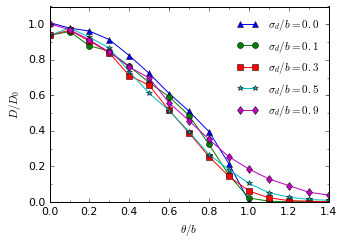

$\sigma_d/b = 0.0$ [  4.52248989e+03   1.45647116e+00]
$\sigma_d/b = 0.1$ [  2.28991027e+03   1.31445094e+00]
$\sigma_d/b = 0.3$ [ 1145.44666871     1.17555934]
$\sigma_d/b = 0.5$ [ 774.53746686    1.11697811]
$\sigma_d/b = 0.9$ [ 352.05501851    1.01896892]


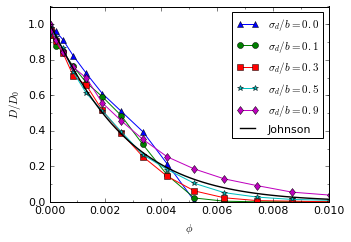

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


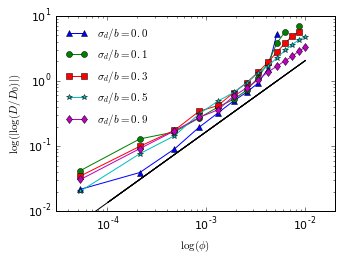

In [24]:
# Data for d=0
# triggerArr = ['normal']
# d0data, dummy = getTriggerData(triggerArr)
# labeld0=['$\sigma_d/b=0$']



##### TODO LOAD BETTER DATA FROM SHELDON FOR d=5 and small p
a=0;k='1.000';u=0
dArr=[0,1,3,5,9]
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,k='1.000',kop=0) for d in dArr]
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
plotdata(dataArr,r'\theta/b',titleArr,linestyles='markers',loglog=False,tofile=True,
         xlim=[0,1.4],filename='D_over_p_vary_d_u0_a0',fitexp=False,plotfit=False)
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aoptest,True)
pArr=np.arange(0.02,1.4,0.02)
titleArr+=['Johnson']
#dataArr+=[np.array([[phiOverlap(p*aoptest),6*Johnson(p=p,a=p*aoptest)] for p in pArr])]
#lsArr+=['--']
plotdata(dataArr,'\phi',titleArr,linestyles='markers',noshow=True,loglog=False,fitexp=True,plotfit=False)
plt.plot(phiOverlap(pArr*aoptest),Johnson(pArr,pArr*aoptest),label='Johnson',color='k',lw=1.4)
plt.xlim([0,0.01])
plt.legend(fontsize='medium')
#plottofile(filename='D_over_phi_vary_d_u0_a0')
plt.show()
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=True,tofile=True,filename='D_over_phi_vary_d_u0_a0_log',fitexp=False,
         plotfit=False,alph=310,nu=1.09,xlim=[3e-5,2e-2],ylim=[1e-2,10])

### Conclusion:
For the p=0.9b line the loglog-log plot shows an almost straight line, except for the p=0.1b data for which I need to use a smaller timestep dt=0.0001

Agreement is found to random polymer lattice model by Johnson for $\sigma_d=0.5b$.


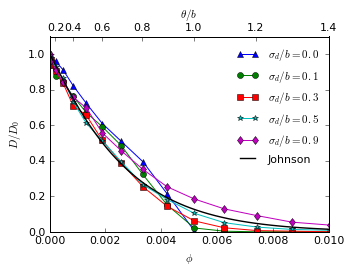

In [29]:
# Data for d=0
# triggerArr = ['normal']
# d0data, dummy = getTriggerData(triggerArr)
# labeld0=['$\sigma_d/b=0$']



##### TODO LOAD BETTER DATA FROM SHELDON FOR d=5 and small p
a=0;k='1.000';u=0
dArr=[0,1,3,5,9]
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,k='1.000',kop=0) for d in dArr]
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
ps_data=[dat[:,0] for dat in dataArr]
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aoptest,True)
pArr=np.arange(0.02,1.4,0.02)
titleArr+=['Johnson']
#dataArr+=[np.array([[phiOverlap(p*aoptest),6*Johnson(p=p,a=p*aoptest)] for p in pArr])]
#lsArr+=['--']
fig = plt.figure(figsize=figsizeRanb)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
for i,data in enumerate(dataArr):
    dd0s=data[:,1]/6.
    xvals=data[:,0]
    ax1.plot(xvals,dd0s,plotmarkers[i],label=titleArr[i])


ax1.set_ylim([0,1.1])
ax1.set_xlim([0,0.01])
ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel("$D/D_0$")

# Top x-axis
pticks = np.array([.2, .4, .6, .8, 1., 1.2, 1.4])
p_tick_locations = phiOverlap(pticks*aoptest)
pticks=["%.1f" % p for p in pticks]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(p_tick_locations)
ax2.set_xticklabels(pticks)
ax2.set_xlabel(r"$\theta/b$")

ax1.plot(phiOverlap(pArr*aoptest),Johnson(pArr,pArr*aoptest),label='Johnson',color='k',lw=1.4)
ax1.legend(fontsize = 'medium',frameon=False)
plottofile(filename='D_over_phi_vary_d_u0_a0')
plt.show()

## D over d vary p

In [29]:
def getDod_p_a_u_k(p,a=0,u=0,k='1.000',trigger='fixb'):
    initfolder=root+"/Documents/workspace-cpp/RanbSPS/Release/sim_data/rand/"
    data=[]
    #TODO implement obtain data for d=0 lattice
    dArr=[]
    for ddir in os.listdir(initfolder):
        if "DS" in ddir: continue   
        d=float(ddir[1:])    
        drel=d/10.
        folder=initfolder+ddir+"/"+trigger
        for dtdir in os.listdir(folder): #search smallest dt first
            file=folder+"/"+dtdir+"/t200/a0/p"+str(p)+'/k'+k+'/u'+str(u)+'/InstantValues/linear_fit_parametersMSD.txt'
            if os.path.isdir(folder):
                if os.path.isfile(file):
                    if d in dArr: continue 
                    dArr.append(d)
                    with open(file, 'r') as fitf:
                        m = (fitf.readline().split('m')[1]).split()[0]
                    data.append([float(drel),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
                #else: print("Error: File not found!\n"+str(file))
    return np.array(sorted(data))

figsize in inches:  [ 5.   3.5]


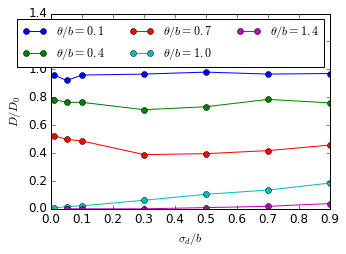

In [61]:
a=0; u=0;
pArr=[1,4,7,10,14]
ddataArr=[getDod_p_a_u_k(p,a,u,k='1.000',trigger='fixb') for p in pArr]

titleArr = [r'$\theta/b = '+str(p/10.)+'$' for p in pArr]
plotdata(ddataArr,r'\sigma_d/b',titleArr,tofile=True,filename='D_over_d_vary_p_u0_a0',ncol=3,ylim=[0,1.4])

### Conclusion:
* The lines for large particles p=1b and p=1.4b show substantial differences, since they would be immobilized for a cubic lattice. The medium size particles p=0.4b and p=0.7b show some decrease in diffusivity that might just be noise. But for p=0.7b it could also be that the particles get slowed down a little. Nonetheless, **these effects are all very small and maybe uninteresting**. I might have to **re-run those simulations**. The small particles show the same diffusivity except for some noise. The p=0.1b data was recorded with long simulations at small dt=0.0001 and shows completely constant diffusivity, which indicates that there is some noise for the other data points.
* The noise at d=0.5b is due to too short simulations.

## U_0 = 0 and aop>0
First, we plot data with a=0 and aoptest=0.5. This data will be compared to the aop=0.5 data with $a\neq0$. This comparison will allow us to see if there is a substantial difference between **a)** using only the total steric interaction parameter $a+p$ and setting $a=0$ (i.e. allowing parallel cylinders to overlap) OR **b)** performing simulations with nonzero $a$, such that parallel cylinders can not overlap.

$\sigma_d/b = 0.1$ [ 20.82750539   1.42099294]
$\sigma_d/b = 0.5$ [ 14.10751099   1.20094393]
$\sigma_d/b = 0.9$ [ 9.3250964   1.10521829]


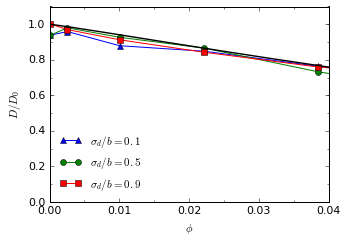

$\sigma_d/b = 0.1$ [ 107.45991881    1.63576408]
$\sigma_d/b = 0.5$ [ 36.96238277   1.20160816]
$\sigma_d/b = 0.9$ [ 24.96829432   1.14838957]


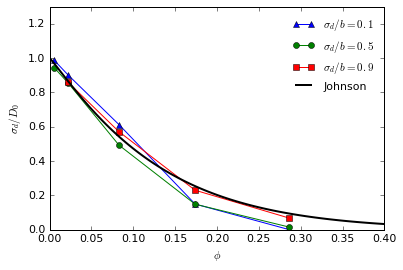

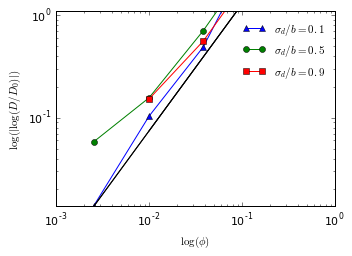

In [40]:
# a) a=0 and aoptest=0.5
a=0;k='1.000';u=0
dArr=[1,5,9]
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,k='1.000',kop=0) for d in dArr]
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
#plotdata(dataArr+d0data,'p/b',titleArr+labeld0,linestyles='',loglog=False,tofile=True,filename='D_over_p_vary_d_u0_a0',fitexp=False,plotfit=False)
aoptest=0.5 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aoptest,True)
lsArr=len(dataArr)*['o-']
pArr=np.arange(0.01,1.4,0.01)
titleArr+=['Johnson']
#dataArr+=[np.array([[phiOverlap(p*aoptest),6*Johnson(p=p,a=p*aoptest)] for p in pArr])]
#lsArr+=['--']
plotdata(dataArr,'\phi',titleArr,linestyles='markers',noshow=True,loglog=False,fitexp=True,plotfit=False)
plt.plot(phiOverlap(pArr*aoptest),Johnson(pArr,pArr*aoptest),label='Johnson',color='k',lw=1.4)
#plt.show()
#plottofile(filename='D_over_phi_vary_d_u0_a0')
plt.xlim([0,0.04])
plt.show()
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_d_u0_a0_log',fitexp=False,plotfit=False)

# b) a!=0 and aop=0.5
aop=0.5;k='1.000';u=0
dArr=[1, 5, 9]
dataArr=[getDop_kop_k_aop_U_d(aop,u=u,k=k,d=d) for d in dArr]
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
lsArr=2*['o-']
### Johnson
pArr=np.arange(0.01,1,0.01)
aArr=pArr*aop
titleArr+=['x']
for i,data in enumerate(dataArr):
    dd0s=data[:,1]/6.
    prels=data[:,0]
    phis=phiOverlap(prels*aop)
    plt.plot(phis,dd0s,plotmarkers[i],label=titleArr[i])
plt.ylim([0,1.3])
plt.xlim([0,0.4])
plt.xlabel("$\phi$")
plt.ylabel("$\sigma_d/D_0$")
#plt.legend()
plt.plot(phiOverlap(pArr*aop),Johnson(pArr,aArr),label='Johnson',color='k',lw=2.0)
plt.legend(loc=0, ncol=1,fontsize='medium',frameon=False)
plottofile('D_over_phi_Johnson_aop05')
#plt.show()
for data in dataArr:
    ptoPhi(data,aoptest,True)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=True,tofile=True,filename='D_over_phi_aop05_log',fitexp=True,
         plotfit=False,alph=22,nu=1.237)


### Conclusion:
- Case a) and b) are qualitatively extremely similar. This indicates that it's enough to just use a total steric paramter $a+p$. In principle, I still need to verify whether this is also the case for nonzero interaction potential $U_0$. BUT, so far, we only study the case of $a=0$, i.e. small $p>a$. In this case, it makes little difference if we use $a=0$ or $a\neq0$.

### EXPERIMENTAL DATA COMPARE
Like in Phillips2000

In [26]:
def phillipsDD0(phi,aop):
    lam=aop
    n=0.174 * np.log(59.6*lam)
    f=(1+1./aop)**2 * phi
    return np.exp(-np.pi * phi**n  -  0.84*f**1.09)


In [27]:
def getDataFile(fileName):
    # Get data from files 
    DoverPhiFile = root + "/Documents/reports-talk-etc/reports/HIforBD/figures/"+fileName
    data = []
    with open(DoverPhiFile, 'rt') as csvfile:
        readerX = csv.reader(csvfile,delimiter=',')
        for row in readerX:
            data.append(row)
    return (np.asarray(data[1:])).astype(float)

[ 0.01   0.022  0.04   0.07   0.1    0.13   0.16   0.19   0.22 ] [ 6.22428454  5.84084192  5.18145465  4.07249462  2.71371766  1.27563626
  0.38087471  0.08809494  0.01267368]


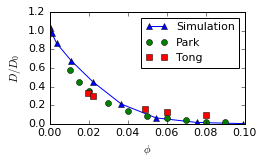

[ 0.02  0.07  0.12  0.17  0.23  0.27]


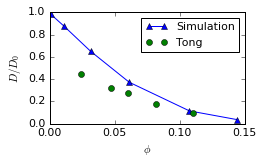

[ 0.01  0.03  0.05  0.08  0.1   0.13  0.15]


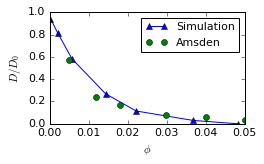

In [39]:
fileName="dataParkFig2.csv"
ExpData=getDataFile(fileName)
fileName="dataTongFig2.csv"
ExpData2=getDataFile(fileName)

smallfigsize=(3.5,2)

aop=0.18
k='1.000';u=0
d=5
SimData=(getDop_kop_k_aop_U_d(aop,u=u,k=k,d=d,dt='0.0001'))
fig = plt.figure(figsize=smallfigsize)
plt.plot(phiOverlap(SimData[:,0]*aop),SimData[:,1]/6.,'^-',label='Simulation')
plt.plot(ExpData[:,0],ExpData[:,1],'o',label='Park')
plt.plot(ExpData2[:,0],ExpData2[:,1],'s',label='Tong')
print(SimData[:,0]*aop,SimData[:,1])
plt.xlabel(r'$\phi$')
plt.ylabel(r'$D/D_0$')
plt.legend(fontsize = 'medium')
plottofile('DoPhiParkTong_aop018')
plt.show()


fileName="dataTongFig1.csv"
ExpData=getDataFile(fileName)


aop=0.32
k='1.000';u=0
d=5
SimData=(getDop_kop_k_aop_U_d(aop,u=u,k=k,d=d,dt='0.0001'))
print(SimData[:,0]*aop)
fig = plt.figure(figsize=smallfigsize)
plt.plot(phiOverlap(SimData[:,0]*aop),SimData[:,1]/6.,'^-',label='Simulation')
plt.plot(ExpData[:,0],ExpData[:,1],'o',label='Tong')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$D/D_0$')
plt.legend(fontsize = 'medium')
plt.locator_params(axis='x',nbins=5)#reduce number of x ticks
plottofile('DoPhiTong_aop032')
plt.show()

fileName="dataAmsdenFig3.csv"
ExpData=getDataFile(fileName)

# TODO Reload data from sheldon
aop=0.1
k='1.000';u=0
d=9
SimData=(getDop_kop_k_aop_U_d(aop,u=u,k=k,d=d,dt='0.0001'))
print(SimData[:,0]*aop)
fig = plt.figure(figsize=smallfigsize)
plt.plot(phiOverlap(SimData[:,0]*aop),SimData[:,1]/6.,'^-',label='Simulation')
plt.plot(ExpData[:,0],ExpData[:,1],'o',label='Amsden')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$D/D_0$')
plt.legend(fontsize = 'medium')
plottofile('DoPhiAmsden_aop01')
plt.show()


________________
________________
________________
________________
# $U_0$ activated


# TODO Test if there is any difference between using zero a or nonzero a for U_0!=0.
- There should not be a substantial difference really, except for large a (phi) plus large d *which, as a system, does not make any sense to investigate really, since there is no room for the polymers place themselfs randomly*. To investigate large a cases, I should use the ranRod+Ranb model with a broad distribution like gamma4.
- If it turns out that there is no big difference, I can basically stick to using a=0 and look at small aop

## a=0 D over p v U k=const 

figsize in inches:  [ 5.   3.5]


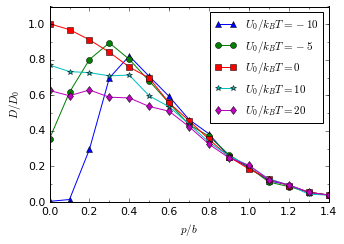

In [130]:
a=0;k='1.000'
d=9
uArr=[-10,-5,0,10,20]
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,k='1.000',kop=0) for u in uArr]
titleArr = ['$U_0/k_BT = '+str(u)+'$' for u in uArr]
plotdata(dataArr,r'p/b',titleArr,linestyles='markers',tofile=True,filename='D_over_p_vary_U_a0_d9')
# NO D over phi Since I use constant k

figsize in inches:  [ 5.   3.5]


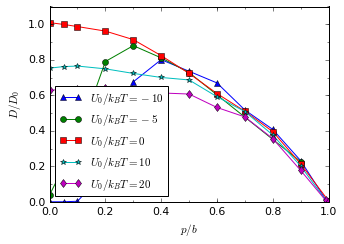

In [131]:
a=0;k='1.000'
d=0
uArr=[-10,-5,0,10,20]
dataArr=[getDop_kop_k_a_U_d(u=u,a=a,d=d,k='1.000',kop=0,MSD='') for u in uArr]
titleArr = ['$U_0/k_BT = '+str(u)+'$' for u in uArr]
plotdata(dataArr,r'p/b',titleArr,linestyles='markers',tofile=True,filename='D_over_p_vary_U_a0_d0')
# NO D over phi Since I use constant k

## a=0 D over phi v d

$\sigma_d/b = 0.0$ [ 81.70949148   0.6892667 ]
$\sigma_d/b = 0.1$ [ 135.490495      0.72582539]
$\sigma_d/b = 0.2$ [ 420.19789101    0.85109593]
$\sigma_d/b = 0.3$ [ 673.39099803    0.90266085]
$\sigma_d/b = 0.5$ [ 659.16545094    0.88916228]
$\sigma_d/b = 0.9$ [ 101.68781754    0.66618516]


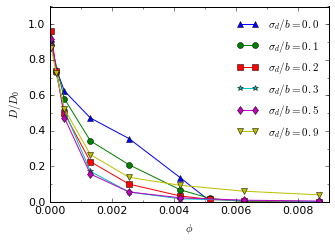

$\sigma_d/b = 0.0$ [ 1.82285593  0.06573018]
$\sigma_d/b = 0.1$ [ 9.08114702  0.29349109]
$\sigma_d/b = 0.2$ [ 30.59592132   0.44013979]
$\sigma_d/b = 0.3$ [ 181.22262439    0.65171066]
$\sigma_d/b = 0.5$ [  1.23525075e+03   8.23488587e-01]
$\sigma_d/b = 0.9$ [  1.50854215e+03   8.42432372e-01]


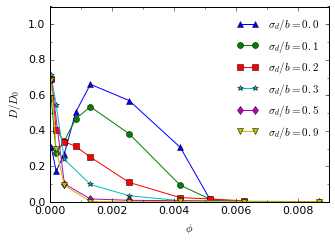

In [72]:
a=0;
kop=0.5
u=10
dArr=[0,1,2,3,5,9]
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
dataArr=[getDop_kop_k_a_U_d(u=u,a=a,d=d,kop=kop) for d in dArr]
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
for data in dataArr:
    ptoPhi(data,aoptest,True)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=False,tofile=True,
         xlim=[0,0.009],filename='D_over_phi_vary_d_a0_kop05_u10',fitexp=True,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_log',fitexp=False,plotfit=False)

u=-10
dArr=[0,1,2,3,5,9]
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
dataArr=[getDop_kop_k_a_U_d(u=u,a=a,d=d,kop=kop) for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
for data in dataArr:
    ptoPhi(data,aop=aoptest,zeroa=True)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=False,tofile=True,
         xlim=[0,0.009],filename='D_over_phi_vary_d_a0_kop05_u-10',fitexp=True,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_log',fitexp=False,plotfit=False)

$\sigma_d/b = 0.0$ [ 607.761317      1.06537441]
$\sigma_d/b = 0.1$ [ 627.42012449    1.04514152]
$\sigma_d/b = 0.2$ [ 569.84034114    0.96811856]
$\sigma_d/b = 0.3$ [ 315.4022845     0.87114397]
$\sigma_d/b = 0.5$ [ 329.32835598    0.8777092 ]
$\sigma_d/b = 0.9$ [ 95.55618451   0.71868817]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


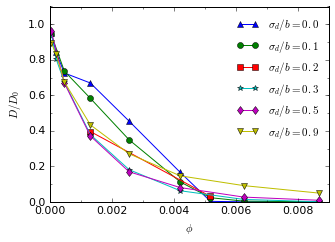

$\sigma_d/b = 0.0$ [  1.13932006e+04   1.56310271e+00]
$\sigma_d/b = 0.1$ [  3.49278189e+03   1.37946140e+00]
$\sigma_d/b = 0.2$ [  1.64224164e+04   1.60413835e+00]
$\sigma_d/b = 0.3$ [ 321.43531964    0.91428836]
$\sigma_d/b = 0.5$ [ 346.22957109    0.8968067 ]
$\sigma_d/b = 0.9$ [ 274.62553388    0.84191968]


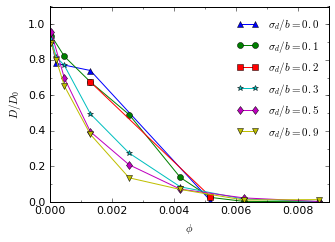

In [63]:
#TODO add d=0
a=0;
kop=0.5
u=5
dArr=[0,1,2,3,5,9]
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
dataArr=[getDop_kop_k_a_U_d(u=u,a=a,d=d,kop=kop) for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
for data in dataArr:
    ptoPhi(data,aop=aoptest,zeroa=True)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=False,tofile=True,filename='D_over_phi_vary_d_a0_kop05_u5',
         xlim=[0,0.009],fitexp=True,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_log',fitexp=False,plotfit=False)

u=-5
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
dataArr=[getDop_kop_k_a_U_d(u=u,a=a,d=d,kop=kop) for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
for data in dataArr:
    ptoPhi(data,aop=aoptest,zeroa=True)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=False,tofile=True,filename='D_over_phi_vary_d_a0_kop05_u-5',
         xlim=[0,0.009],fitexp=True,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_log',fitexp=False,plotfit=False)

$\sigma_d/b = 0.0$ [ 11.61248389   0.39207222]
$\sigma_d/b = 0.1$ [ 12.89067366   0.32625808]
$\sigma_d/b = 0.2$ [ 65.61572719   0.47560559]
$\sigma_d/b = 0.3$ [  1.66768311e+03   7.97936839e-01]
$\sigma_d/b = 0.5$ [ 504.94244634    0.66185223]
$\sigma_d/b = 0.9$ [ 7.03549258  0.21719228]


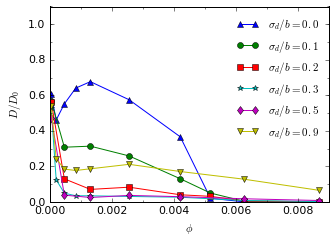

$\sigma_d/b = 0.0$ [ 2.00834235  0.04333571]
$\sigma_d/b = 0.1$ [ 2.77752639  0.03925199]
$\sigma_d/b = 0.2$ [ 4.78252363  0.02864021]
$\sigma_d/b = 0.3$ [ 165.63002998    0.28637934]
$\sigma_d/b = 0.5$ [ 7.74759024  0.0112736 ]
$\sigma_d/b = 0.9$ [  7.20319444e+00   6.25598199e-14]


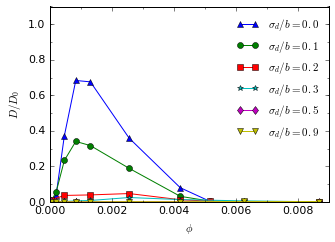

$\sigma_d/b = 0.0$ [ 5.98875824  0.2873915 ]
$\sigma_d/b = 0.1$ [ 10.36634513   0.34646953]
$\sigma_d/b = 0.2$ [ 8.00405259  0.25879117]
$\sigma_d/b = 0.3$ [ 7.08401084  0.19826327]
$\sigma_d/b = 0.5$ [ 9.93317477  0.20253011]
$\sigma_d/b = 0.9$ [ 10.8901254    0.19514543]


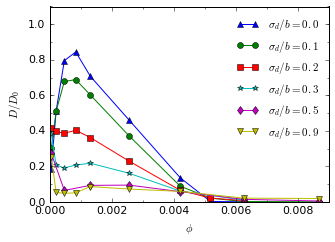

In [73]:
a=0;
kop=1.5
u=10
dArr=[0,1,2,3,5,9]
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
dataArr=[getDop_kop_k_a_U_d(u=u,a=a,d=d,kop=kop) for d in dArr]
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
for data in dataArr:
    ptoPhi(data,aoptest,True)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=False,tofile=True,filename='D_over_phi_vary_d_a0_kop15_u10',
         xlim=[0,0.009],fitexp=True,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_log',fitexp=False,plotfit=False)

u=-10
dataArr=[getDop_kop_k_a_U_d(u=u,a=a,d=d,kop=kop) for d in dArr]
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
for data in dataArr:
    ptoPhi(data,aoptest,True)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=False,tofile=True,filename='D_over_phi_vary_d_a0_kop15_u-10',
         xlim=[0,0.009], fitexp=True,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_log',fitexp=False,plotfit=False)

u=-5
dataArr=[getDop_kop_k_a_U_d(u=u,a=a,d=d,kop=kop) for d in dArr]
titleArr = ['$\sigma_d/b = '+str(d/10.)+'$' for d in dArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
for data in dataArr:
    ptoPhi(data,aoptest,True)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=False,tofile=True,filename='D_over_phi_vary_d_a0_kop15_u-5',
         xlim=[0,0.009], fitexp=True,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_log',fitexp=False,plotfit=False)

## a=0 D over p v U w kop

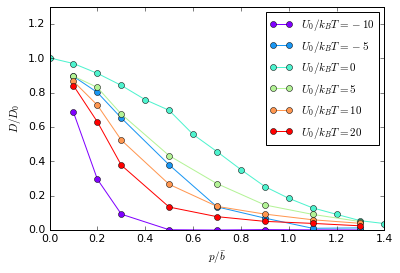

$U_0/k_BT = -10$ [  1.50854215e+03   8.42432372e-01]
$U_0/k_BT = -5$ [ 274.62553388    0.84191968]
$U_0/k_BT = 0$ [ 352.05501851    1.01896892]
$U_0/k_BT = 5$ [ 95.55618451   0.71868817]
$U_0/k_BT = 10$ [ 101.68781754    0.66618516]
$U_0/k_BT = 20$ [ 233.42585012    0.72660276]


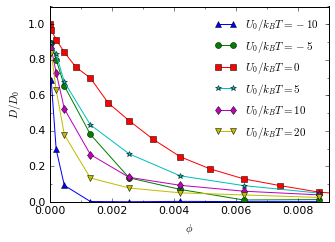

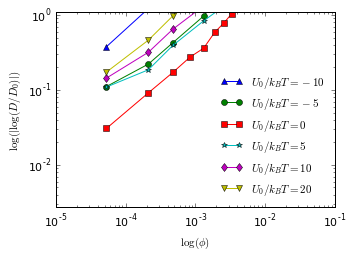

In [22]:
a=0;
kop=0.5
d=9
uArr=[-10,-5,0,5,10,20]
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop) for u in uArr]
titleArr = ['$U_0/k_BT = '+str(u)+'$' for u in uArr]
plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aoptest,True)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=False,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9',
         xlim=[0,0.009],fitexp=True,plotfit=False)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d9_log',fitexp=False,plotfit=False)


#### Conclusion:
- The interaction potential seems to conserve the stretched exp for intermediate phi. 
- also, for the stretched exp $$exp(-\alpha \phi^\nu)$$ $\nu$ seems to be conserved, but $\alpha$ changes.
- I get a some noise for large phi in the log plot, which I think can be attributed to the 'sudden disappearance' and appearance of rods in my system for large $\sigma_d$. I may have to simulate a larger system, but it's not so important, since my results are rather qualitative.
- *Interesting:* For attractive $U_0=-5$ and $-10 k_BT$, using a large $\sigma_d=0.9b$ leads to a much stronger hindrance effect, in comparison to the case for $\sigma_d=0.9b$. Need to plot D over p vary d and U
- **Note** I was expecting a behavior like in our bpj paper figure4. There, the diffusvity increases towards increasing ion concentrations. It turns out that this is due to the fact that **the ion concentration changes**, when the polymer volume fraction changes, and therefore kop changes.

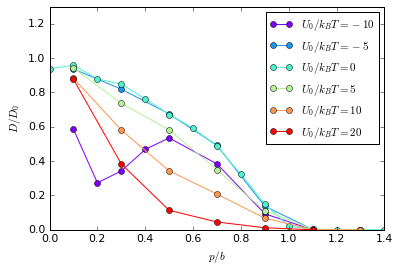

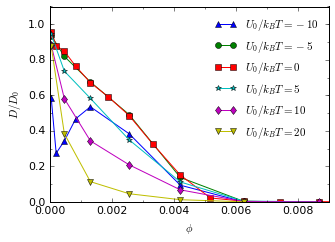

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


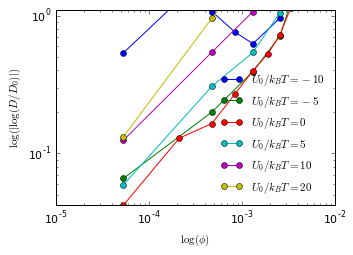

In [23]:
# TODO U=20 from sheldon
a=0;
kop=0.5
d=1
uArr=[-10,-5,0,5,10,20]
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop) for u in uArr]
titleArr = ['$U_0/k_BT = '+str(u)+'$' for u in uArr]
plotdataArr(dataArr,r'p/b',lineArr=titleArr)
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aoptest,True)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=False,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d1',
         xlim=[0,0.009], fitexp=False,plotfit=False)
plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop05_d1_log',fitexp=False,plotfit=False)


### Conclusion:
In an ordered $\sigma_d=0.1b$ system we find that the strong hindrance effect at small $\phi$ of attractive interaction potentials $U_0=-5, -10k_BT$ almost disappears for increasing $\phi$. This is in agreement to our findings in the HI report, namely that there is an inversion of the charge asymmetry for large $\phi$. For large $\phi$ repulsive tracer particles are more strongly immobilized and repulsive tracer particles more mobile. For small $\phi$ vice versa. 

Comparing D over phi vary U for $\sigma_d=0.1b$ and $\sigma_d=0.9b$ we find that an attractive interaction potential with $U_0=-5, -10 k_BT$ has little effect on the diffusivity in the ordered lattice, $\sigma_d=0.1b$, in comparison to the unorderd lattice $\sigma_d=0.9b$ where it has a strong hindrance effect. In particular, we do not see the inversion of charge asymmetry. The strong attractive tracer particle with $U_0=-10k_BT$ has the lowest diffusivities over the whole range of $\phi$.

### D over p with kop=0.5 and d=3,9 + U=-10,0,10

figsize in inches:  [ 5.   3.5]


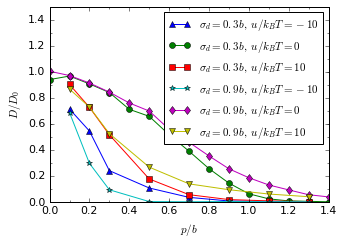

figsize in inches:  [ 5.   3.5]


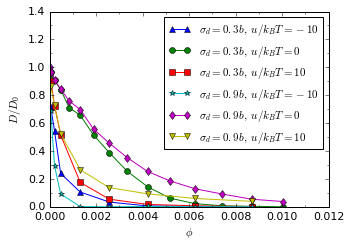

In [138]:
a=0;
kop=0.5
uArr=[-10,0,10]
d=3
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop) for u in uArr]
titleArr = ['$\sigma_d=0.3b,\;u/k_BT = '+str(u)+'$' for u in uArr]
d=9
dataArr+=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop) for u in uArr]
titleArr+=['$\sigma_d=0.9b,\;u/k_BT = '+str(u)+'$' for u in uArr]
plotdata(dataArr,'p/b',titleArr,linestyles='markers',ylim=[0,1.5],loglog=False,tofile=True,filename='D_over_p_vary_U_d3and9_a0_kop05',fitexp=False,plotfit=False)
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aoptest,True)
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
plotdata(dataArr,'\phi',titleArr,linestyles='markers',ylim=[0,1.4],loglog=False,tofile=True,filename='D_over_phi_vary_U_d3and9_a0_kop05',fitexp=False,plotfit=False)
#plotdata(dataArr,'\phi',titleArr,linestyles='markers',loglog=True,tofile=True,filename='D_over_phi_vary_d_u0_a0_log',fitexp=False,plotfit=False)
#plotDoPhi(aoptest,dataArr,titleArr,loglog=False)
#plotDoPhi(aoptest,dataArr,titleArr,loglog=True)

#### Conclusion:
##### Interesting!
The d=0.9b shows a stronger decrease in diffusivity than the d=0.3b data for attractive interactions $U_0=-10k_BT$ but in the repulsive case the decrease it is the other way around, although the effect is much weaker, considering that for large $p/b$ the d=0.9b data shows higher diffusivities than the d=0.3b data for U_0=0

### larger kop=1 and 1.5 for d=0.9

$U_0/k_BT = -10$ [ 134.30426638    0.3483675 ]
$U_0/k_BT = -5$ [ 228.91239626    0.61281325]
$U_0/k_BT = 10$ [ 67.42688713   0.51988838]
$U_0/k_BT = 20$ [ 66.87123254   0.47720832]
figsize in inches:  [ 5.   3.5]


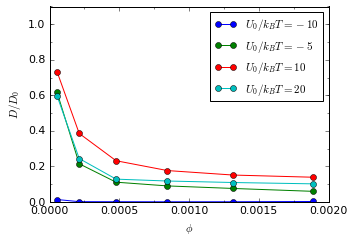

figsize in inches:  [ 5.   3.5]


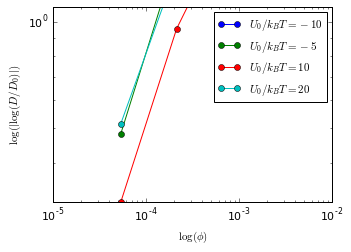

$U_0/k_BT = -10$ [  7.20319444e+00   6.25598199e-14]
$U_0/k_BT = -5$ [ 10.8901254    0.19514543]
$U_0/k_BT = 0$ [ 352.05501851    1.01896892]
$U_0/k_BT = 10$ [ 7.03549258  0.21719228]
$U_0/k_BT = 20$ [ 5.14954455  0.14491897]
figsize in inches:  [ 5.   3.5]


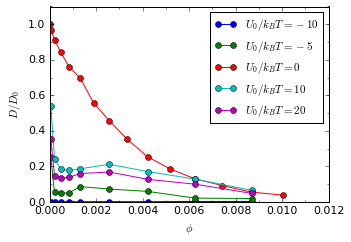

figsize in inches:  [ 5.   3.5]


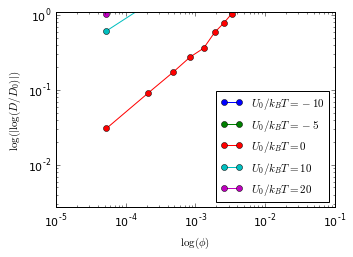

In [139]:
kop=1
d=9
uArr=[-10,-5,10,20]
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop) for u in uArr]
titleArr = ['$U_0/k_BT = '+str(u)+'$' for u in uArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aoptest,True)
plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=False,tofile=True,filename='D_over_phi_vary_U_a0_kop1_d9',fitexp=True,plotfit=False)
plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop1_d9_log',fitexp=False,plotfit=False)

kop=1.5
d=9
uArr=[-10,-5,0,10,20]
dataArr=[getDop_kop_k_a_U_d(u,a,d=d,kop=kop) for u in uArr]
titleArr = ['$U_0/k_BT = '+str(u)+'$' for u in uArr]
#plotdataArr(dataArr,r'p/\bar{b}',lineArr=titleArr)
aoptest=0.05 # Here a=0, i.e. the cylinders are lines. Therefore we are using a small dummy aop
for data in dataArr:
    ptoPhi(data,aoptest,True)
plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=False,tofile=True,filename='D_over_phi_vary_U_a0_kop15_d9',fitexp=True,plotfit=False)
plotdata(dataArr,'\phi',titleArr,linestyles='',loglog=True,tofile=True,filename='D_over_phi_vary_U_a0_kop15_d9_log',fitexp=False,plotfit=False)

## D over d p=0 a=0 U_0!=0 k=0.5, 1, 2

figsize in inches:  [ 5.   3.5]


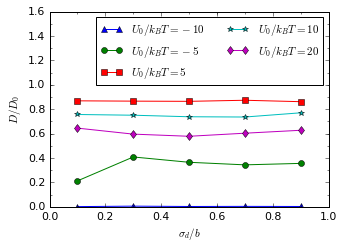

figsize in inches:  [ 5.   3.5]


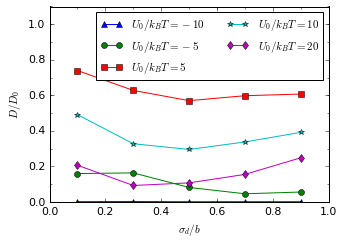

In [140]:
# Vary U
a=0; p=0; k='1.000'
Arr=[-10,-5,5,10,20]
ddataArr=[getDod_p_a_u_k(p,a,u=x,k=k,trigger='fixb') for x in Arr]
titleArr = ['$U_0/k_BT = '+str(x)+'$' for x in Arr]
plotdata(ddataArr,r'\sigma_d/b',titleArr,linestyles='markers',ncol=2,ylim=[0,1.6])
# Vary U
a=0; p=0; k='2.000'
Arr=[-10,-5,5,10,20]
ddataArr=[getDod_p_a_u_k(p,a,u=x,k=k,trigger='fixb') for x in Arr]
titleArr = ['$U_0/k_BT = '+str(x)+'$' for x in Arr]
plotdata(ddataArr,r'\sigma_d/b',titleArr,linestyles='markers',ncol=2,tofile=True,filename='D_over_d_vary_U_a0_p0_k2')

#### Conclusion: 
- There is no visible effect to changing d for point particles at $k=0.05b$ and $k=0.1b$, but at long interaction range $k=0.2b$. In principle, this shows that any effect of changing d will mostly be due to change of steric interactions. 
- **NEW CHARGE ASYMMETRY:** For a relatively large range $k=0.2b$ we see a clear increase in diffusivity for increasing d at repulsive $U_0$ and a decrease at attractive $U_0$. For $U_0=-5k_BT$ the diffusivity decreases twofold from d=0.3b to d=0.9b and for $U_0=20k_BT$ it increases twofold. Why is this? Maybe because for large d it is more likely that two attractive fibers are very close together to double their effect. For the repulsive case it's pretty clear that the potential landscape simply "washes out", i.e. the minimum in the center of the box for small d.

#### TODO:
* maybe it would be interesting to have a look at this in combination with a steric effect, i.e. D over d vary U for p=5, 7, 10, 14 or so (NOTE: Below in the D over U data it looks as though for p=0.2b the effect might be interesting at $U_0=-10k_BT$

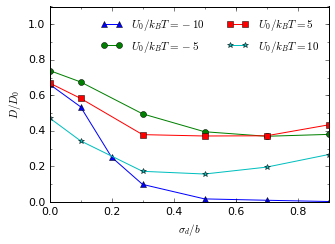

Phi: 5.87280855595e-05


In [31]:
#### TODO ADD d=0 data running on yoshi
# Vary U
a=0; p=5; k='2.500'
Arr=[-10,-5,5,10]
ddataArr=[getDod_p_a_u_k(p,a,u=x,k=k,trigger='fixb') for x in Arr]
titleArr = ['$U_0/k_BT = '+str(x)+'$' for x in Arr]
plotdata(ddataArr,r'\sigma_d/b',titleArr,linestyles='markers',ncol=2,ylim=[0,1.1],xlim=[0,0.9],tofile=True,filename='D_over_d_vary_U_kop05_a0_p5')
print("Phi:",phiOverlap(p*0.01/10))

## D over U

In [142]:
# get D over p data for fixed kop aop and U in order to plot D over phi for different U_0
def getDoU_k_a_p_d(k='1.000',p=0,a=0,trigger='fixb',system='rand',d=0,MSD='MSD'):
    initfolder=root+"/Documents/workspace-cpp/RanbSPS/Release/sim_data/"
    adir="a"+str(a)
    if system=='rand':
        initfolder+="rand/d"+str(d)+"/"
    if trigger=='fixb':
        initfolder+="fixb/"
    else: 
        return 'TODO'
    if trigger=='fixb' and d==0:
        initfolder=root+"/Documents/workspace-cpp/SingleParticleSimulation/sim_dataOLD/noreset/"
        adir="d0/b10"
    # folder=initfolder+'dt'+dt+'/t200/'+adir
    data=[]
    #print(folder)
    uArr=[]        
    for dtdir in os.listdir(initfolder): #search smallest dt first
        folder=initfolder+"/"+dtdir+"/t200/"+adir+'/p'+str(p)+'/k'+k
        if os.path.isdir(folder):
            for udir in os.listdir(folder): 
                if "DS" in udir: continue
                #print(folder+'/'+udir)
                u=float(udir[1:])
                if u in uArr: continue
                file=os.path.join(folder,udir,'InstantValues/linear_fit_parameters'+MSD+'.txt')
                #print(file)
                if os.path.isfile(file):
                    uArr.append(u)
                    #print(file)
                    with open(file, 'r') as fitf:
                        m = (fitf.readline().split('m')[1]).split()[0]
                    data.append([float(u),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
                #else: print("Error: File not found!\n"+str(file))
    return np.array(sorted(data))

figsize in inches:  [ 5.   3.5]


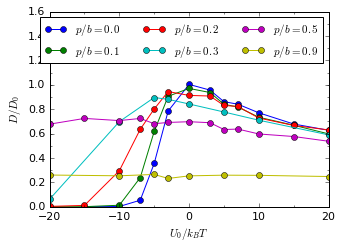

figsize in inches:  [ 5.   3.5]


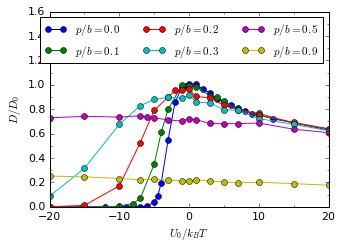

In [143]:
# Do U v p d=9
a=0; k='1.000'; d=9
Arr=[0,1,2,3,5,9]
dataArr=[getDoU_k_a_p_d(k=k,p=x,a=a,d=d) for x in Arr]
titleArr = ['$p/b = '+str(x/10.)+'$' for x in Arr]
plotdata(dataArr,r'U_0/k_BT',titleArr,ncol=3,ylim=[0,1.6],xlim=[-20,20])

# Do U v p d=3
a=0; k='1.000'; d=0
Arr=[0,1,2,3,5,9]
dataArr=[getDoU_k_a_p_d(k=k,p=x,a=a,d=d,MSD='') for x in Arr]
#dataArr+=[getDoU_k_a_p_d(k=k,p=1,a=a,d=d,dt='0.0001')]
titleArr = ['$p/b = '+str(x/10.)+'$' for x in Arr]+['$p/b=0.1$']
plotdata(dataArr,r'U_0/k_BT',titleArr,ncol=3,ylim=[0,1.6],xlim=[-20,20])

figsize in inches:  [ 5.   3.5]


UnboundLocalError: local variable 'ax' referenced before assignment

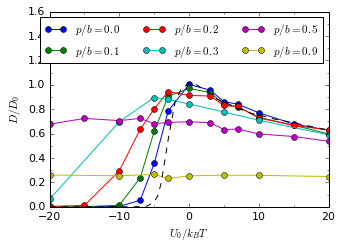

In [144]:
# Do U v p d=9
a=0; k='1.000'; d=9
Arr=[0,1,2,3,5,9]
dataArr=[getDoU_k_a_p_d(k=k,p=x,a=a,d=d) for x in Arr]
titleArr = ['$p/b = '+str(x/10.)+'$' for x in Arr]
plotdata(dataArr,r'U_0/k_BT',titleArr,ncol=3,ylim=[0,1.6],xlim=[-20,20],noshow=True)

# Do U v p d=0
a=0; k='1.000'; d=0
Arr=[0,1,2,3,5,9]
dataArr=[getDoU_k_a_p_d(k=k,p=x,a=a,d=d,MSD='') for x in Arr]
#dataArr+=[getDoU_k_a_p_d(k=k,p=1,a=a,d=d,dt='0.0001')]
titleArr = ['' for x in Arr]
lsArr=['k--' for x in Arr]
plotdata(dataArr,r'U_0/k_BT',titleArr,linestyles=lsArr,ncol=3,ylim=[0,1.6],xlim=[-20,20],addfig=True)

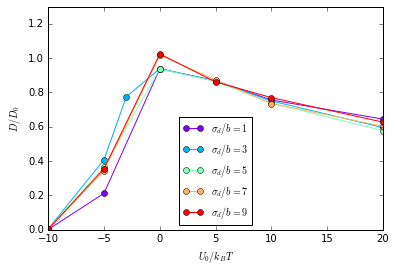

In [87]:
# Do U vary d p=0
a=0; k='1.000'; p=0
Arr=[1,3,5,7,9]
dataArr=[getDoU_k_a_p_d(k=k,p=p,a=a,d=x) for x in Arr]
titleArr = ['$\sigma_d/b = '+str(x)+'$' for x in Arr]
plotdataArr(dataArr,r'U_0/k_BT',lineArr=titleArr)

#### Conclusion:
- changing d makes no difference for point particles. This shows that our main results from the EPJE paper regarding the charge-asymmetry are valid. Only for very large repulsive potentials $U_0=20k_BT$, there is a small offset and large $\sigma_d$ lead to slightly larger diffusivities.

#### Conclusion:
- The data looks qualitatively the same for d=0.3b and d=0.9b. The smaller diffusivities for large particles p=0.9b are due to steric effects.
- There seems to be some difference for p=0.2b at $U_0=-10 k_BT$ so maybe I could **(TODO) plot D over d v U for p=0.2b k=0.1b**. But I am unsure if this is really interesting... It might demonstrate that for small particles changing the pore opening distribution in combination with changing $U_0$ has some intersting charge-asymmetric effect.

- **TODO** re-record data for p=1 with dt=0.0001

# TODO D over U vary phi (i.e. fix kop) running on sheldon

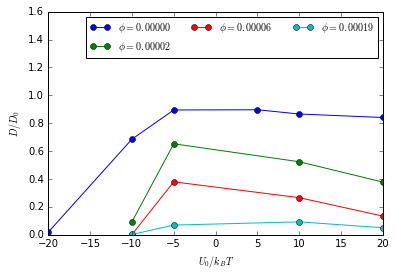

In [63]:
# Do U v p d=9
a=0; kop=0.5; d=9
aoptest=0.05
Arr=[1,3,5,9]
dataArr=[getDoU_k_a_p_d(k=str("{0:.3f}".format(kop*x)),p=x,a=a,d=d) for x in Arr]
#print(dataArr)
titleArr = ['$\phi = '+str("{0:.5f}".format(phiOverlap(x/10.*aoptest)))+'$' for x in Arr]
plotdata(dataArr,r'U_0/k_BT',titleArr,ncol=3,ylim=[0,1.6],xlim=[-20,20])

### TODO Record and evaluate aop data 

In [62]:
# TODO as above but with aop=x
#### d = 9 ###
kop=x; aop=0.5; d=9
uArr=[-20,-10,-5,0,5,10,20];
pdataArr = [getDop_kop_aop_U_d(aop,kop,u,trigger='fixb',system='rand',d=0) for u in uArr]
labels=['$U_0/k_BT =$'str(u) for u in uArr]
plotDoPhivarylub(aop,pdataArr,labels)
plotDoPhivarylub(aop,pdataArr,labels,loglog=True)

SyntaxError: invalid syntax (<ipython-input-62-21d9a66f0a76>, line 6)

# TODO evaluate
- D over U vary phi (i.e. fix kop with a=0 -- set aop as small e.g. aop=0.01) running on sheldon
- D over d vary phi (fix kop with)

# TODO  record maybe
 - aop=0.5 kop=0.5, 1, 2 data with d=3,9 and u=-20,-10,-5,5,10,20 (first have a look at the data for a=0,i.e. very small aop=0.01)
 - D over phi with aop= 1 2 and U_0=0 to see if $aop<2$ is not so good *NOTE:* I still allow some overlap between the cylinders when they are orthogonal to each other. This makes no difference at small phi, but at larger phi it may be problematic (simply because phi is not definitive then). I should therefore, probably use the overlap version for calculating phi
 - D over d vary p for U_0!=0 with k or kop
 - D over p/phi data like Phillips2000 

# TODO rand:
- Run simulations with differen **polymer volume fraction** with $U_0\neq 0$, i.e. fixed kop and aop (*or just change $\bar{b}$ and keep the rest constant.*)
  * Note that I should not set the interaction range to high. Only up to about $k=0.4b$.
- compare the results to the BD data by Johansson1993a on charged ion diffusion in unordered polymer systems with attractive electrostatic interactions (fig. 2)
- One can see that for ranRod+Ranb with gamma(2.5,4), i.e. a very broad distribution of pore openings, the diffusivity gets much higher for larger particles with $p/b>0.5$ than even for the rand model, which has a comparably narrow pore size distribution. This indicates two things:
 1. The **ranRod+Ranb model might be suitable to simulate gels with a very broad distribution of pore openings**, like some mucus gels as reported by Lai et al (I have to look for the specific papers)
 2. It might be useful to extend the rand model to a larger system (i.e. W=4 or 5), such that I can use a broader pore size distribution with d larger than 0.9b. *But* this will still not really generate large regions without rods, like to ranRod+Ranb model potentially can. It might be interesting to analyze the distribution of distances $\rho$ for ranRod+Ranb with gamma(2.5,4) for attractive and repulsive $U_0$.


### TODO  Evaluate simulations
* D over d vary k for U=-10 -5 5 10 20 and p=0 (same data as evaluated for DodvU)
* D over d vary p for U_0=0 (maybe also run sims for $U_0\neq0$ (compare large and small particles.)
* D over d vary phi const kop for U_0!=0 - Check D over phi vary U for d=9 result to see what phi is interesting

# Compare D over p for Ranb and SPSnoHI

In [18]:
def getTriggerData(triggerArr,U0=0):
    triggerNameArr = []
    a=0# This if fixed here, for no HI
    adir='/a0'
    datadir= root + "/Documents/workspace-cpp"
    afrac = '%g'%(float(a)/10)
    dataArr=[]
    for trigger in triggerArr:
        if trigger == 'normal':
            typedir='/SingleParticleSimulation/sim_dataOLD/noreset/dt0.0001/t200/d0/b10/'
            MSD=''
            adir=''
        elif trigger == 'ranRod/nrods1':
            typedir='/SingleParticleSimulation/Release/sim_data/noreset/'+trigger+'/dt0.0005/t200/d0/b10'
            MSD='MSD'
            adir=''
        else:
            typedir='/RanbSPS/Release/sim_data/'+trigger+'/dt0.0005/t200'
            MSD='MSD'
            adir='/a0'
        triggerNameArr.append(trigger.replace('/',''))
        folder=datadir + typedir + adir
        data = []
        for pdir in os.listdir(folder):
            file=os.path.join(folder, pdir,'k1.000/u'+str(U0)+'/InstantValues/linear_fit_parameters'+str(MSD)+'.txt')
            if os.path.isfile(file):
                p=file.split('/p')[1].split('/k')[0] # assign value from dir to p
                p='%g'%(float(p)/10)                 # make p value p/b
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(p)+a/10.,float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return dataArr, triggerNameArr

### Data with random box size $b$ and fixed cylinder positions at the edges
The particles are very mobile even when they are much bigger than the mesh size.

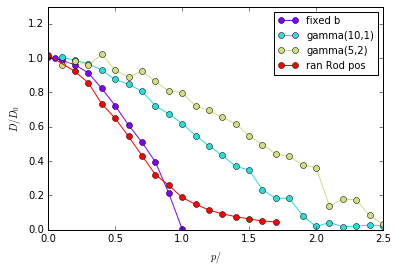

In [10]:
triggerArr = ['normal','gamma','gamma2','ranRod/nrods1']
u0data, dummy = getTriggerData(triggerArr)
triggerNameArr = ['fixed b','gamma(10,1)','gamma(5,2)','ran Rod pos']
plotdataArr(u0data,'p/\bar{b}',lineArr=triggerNameArr)

_________________
________________
__________________
# rand + fixb
## $U_0$ deactivated and a=0
### conclusion
rand with d=9 looks just like ranRod gamma(10,1)

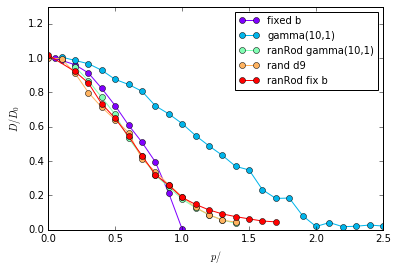

In [11]:
triggerArr = ['normal','gamma','ranRod/gamma','rand/d9/fixb','ranRod/nrods1']
u0data, dummy = getTriggerData(triggerArr)
triggerNameArr = ['fixed b','gamma(10,1)','ranRod gamma(10,1)','rand d9','ranRod fix b']
plotdataArr(u0data,'p/\bar{b}',lineArr=triggerNameArr)

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
____________________________
____________________________
____________________________
____________________________
## Evaluate Ranb+ranRod
####  Data with random $b$ and random cylinder position inside simulation box

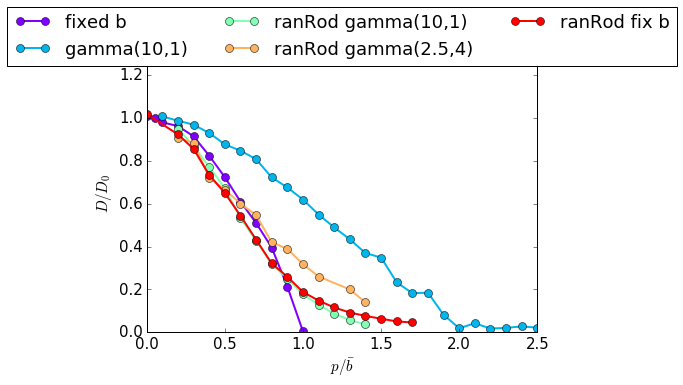

In [54]:
triggerArr = ['normal','gamma','ranRod/gamma','ranRod/gamma4','ranRod/nrods1']
u0data, dummy = getTriggerData(triggerArr)
triggerNameArr = ['fixed b','gamma(10,1)','ranRod gamma(10,1)','ranRod gamma(2.5,4)','ranRod fix b']
plotdataArr(u0data,r'p/\bar{b}',lineArr=triggerNameArr)

### Conclusion:
Looks just like the old ranRod model data with fixed $b$, i.e. we see something like a stretched exponential decrease even without HI.

## Check D over p at nonzero U_0
#### NOTE: These results should also apply for rand with large enough d>5
The range is set to $k=0.1b$.

We still see a maximum at intermediate $p$ for $U_0<0$ and practically constant diffusivities for small $p$ for $U_0>0$.
The less broad gamma(10,1) distribution has a shape

#### Gamma(10,1) distribution

In [11]:
def getDoverpVaryU0Data(u0Arr,k,trigger):
    datadir= root + "/Documents/workspace-cpp/RanbSPS/Release/sim_data/"+trigger+"/dt0.0005/t200"
    dataArr=[]
    for u0 in u0Arr:
        MSD='MSD'
        folder=datadir
        data = []
        for pdir in os.listdir(folder):
            file=os.path.join(folder, pdir,'k'+k+'/u'+str(u0)+'/InstantValues/linear_fit_parameters'+str(MSD)+'.txt')
            if os.path.isfile(file):
                p=file.split('/p')[1].split('/k')[0] # assign value from dir to p
                p='%g'%(float(p)/10)                 # make p value p/b
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(p),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return dataArr

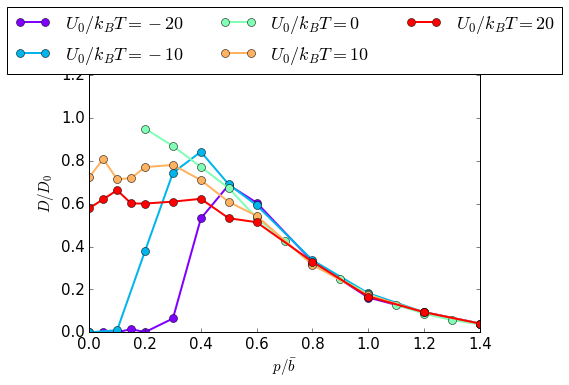

In [55]:
u0Arr = [-20,-10,0,10,20]
k='1.000'
trigger='ranRod/gamma'
lineNameArr = ['$U_0/k_BT = '+str(u)+'$' for u in u0Arr]
data = getDoverpVaryU0Data(u0Arr,k,trigger)
plotdataArr(data,r'p/\bar{b}',lineArr=lineNameArr)

#### Gamma(2.5,4) distribution:
At $p=1b$, a strong attractive interaction potential $U_0=-20k_BT$ leads to increased diffusivity

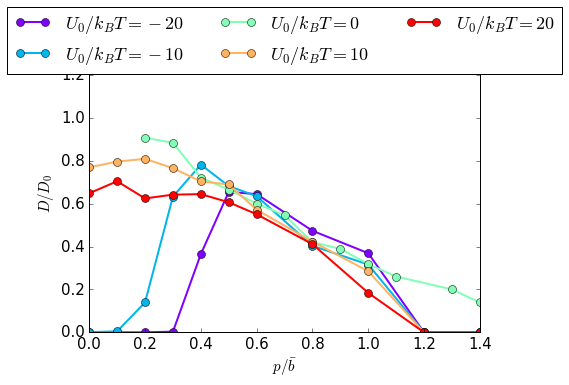

In [56]:
u0Arr = [-20,-10,0,10,20]
k='1.000'
trigger='ranRod/gamma4'
lineNameArr = ['$U_0/k_BT = '+str(u)+'$' for u in u0Arr]
data = getDoverpVaryU0Data(u0Arr,k,trigger)
plotdataArr(data,r'p/\bar{b}',lineArr=lineNameArr)

### Conclusion:
For small $p/b$ there are only little differences between the broad gamma4 and less broad gamma case. For large particles the differences are quite big.
In the gamma4 simulation, the behavior for $p/b>1$ is really interesting. But this may be a bug. 

### D over U for p=0

In [36]:
def getDoverUdata(kArr,p,trigger,dt="0.0005"):
    datadir= root + "/Documents/workspace-cpp/RanbSPS/Release/sim_data/"
    dataArr=[]
    triggerNameArr = []
    for k in kArr:
        MSD='MSD'
        triggerNameArr.append(trigger.replace('/',''))
        folder=datadir +trigger+'/dt'+str(dt)+'/t200/p'+str(p)+'/k'+str(k)+'/'
        data = []
        for udir in os.listdir(folder):
            file=os.path.join(folder, udir,'InstantValues/linear_fit_parametersMSD.txt')
            if os.path.isfile(file):
                u=file.split('/u')[1].split('/I')[0] # assign value from dir to 
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(u),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return dataArr

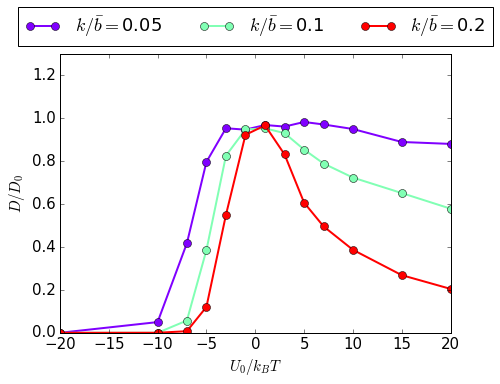

In [59]:
trigger ='ranRod/gamma'
p=0
kArr=['0.500','1.000','2.000']
krelArr=[float(k)/10. for k in kArr]
a=0# This if fixed here, for no HI
ksdata=getDoverUdata(kArr,p,trigger)
plotdataArr(ksdata,r'U_0/k_B T',lineArr=krelArr,lineParam=r'$k/ \bar{b} =$')

### D over U in combination with old cubic periodic data

In [48]:
p=0
ks=['0.500','1.000','2.000']
a=0# This if fixed here, for no HI
datadir= root + "/Documents/workspace-cpp/SingleParticleSimulation/sim_dataOLD/noreset/"
dataArr=[]
for k in ks:
    MSD='MSD'
    triggerNameArr.append(trigger.replace('/',''))
    folder=datadir +'/dt0.0001/t200/d0/b10/p'+str(p)+'/k'+str(k)+'/'
    data = []
    for udir in os.listdir(folder):
        file=os.path.join(folder, udir,'InstantValues/linear_fit_parameters.txt')
        if os.path.isfile(file):
            u=file.split('/u')[1].split('/I')[0] # assign value from dir to 
            with open(file, 'r') as fitf:
                m = (fitf.readline().split('m')[1]).split()[0]
            data.append([float(u),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
    dataArr.append(np.array(sorted(data)))
ksdataOld = (dataArr)

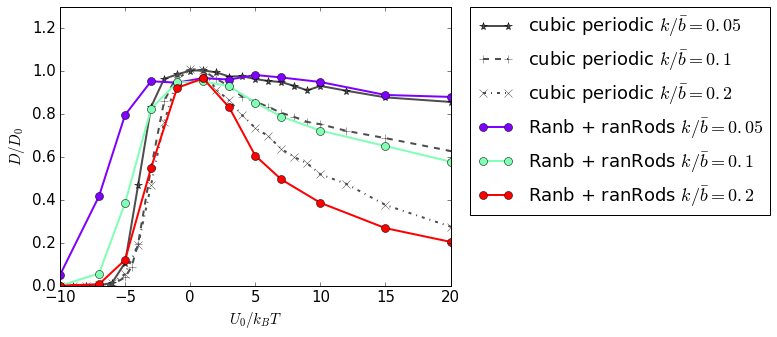

In [61]:
#plotdataArr(ksdata,,lineArr=ks,lineParam='$k$')
ksrel=[float(k)/10. for k in ks]
ksdata=getDoverUdata(kArr,p,trigger)
combinaksData =ksdata + ksdataOld
colors=cm.rainbow(np.linspace(0,1,len(ksdata)))
plt.figure(figsize=(7,5))
lslist= ['*-','+--','x-.']
for i, line in enumerate(ksdataOld):
    ti = r'cubic periodic $k/ \bar{b} =' + str(ksrel[i]) +'$'
    xs = line[:,0]
    dd0s = line[:,1]/6.
    plt.plot(xs,dd0s,lslist[i],label=ti,c='0.3') # '0.75' is shade of grey
lslist=3 * ['o-'] 
for i, line in enumerate(ksdata):
    ti = r'Ranb + ranRods $k/ \bar{b} =' + str(ksrel[i]) +'$'
    xs = line[:,0]
    dd0s = line[:,1]/6.
    plt.plot(xs,dd0s,lslist[i],label=ti,c=colors[i])
plt.xlabel(r'$U_0/k_B T$')
plt.ylabel(r'$D/D_0$')
plt.ylim([0,1.3])
plt.xlim([-10,20])
#plt.legend(loc=2, bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### D over k for p=0

In [42]:
def getDoverkdata(uArr,p,trigger,dt="0.0005"):
    datadir= root + "/Documents/workspace-cpp/RanbSPS/Release/sim_data/"
    dataArr=[]
    triggerNameArr = []
    for u in uArr:
        MSD='MSD'
        triggerNameArr.append(trigger.replace('/',''))
        folder=datadir +trigger+'/dt'+str(dt)+'/t200/p'+str(p)+'/'
        data = []
        for udir in os.listdir(folder):
            file=os.path.join(folder, udir,'u'+str(u)+'/InstantValues/linear_fit_parametersMSD.txt')
            if os.path.isfile(file):
                k=file.split('/k')[1].split('/u')[0] # assign value from dir to k
                krel = float(k)/10.
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(krel),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return dataArr

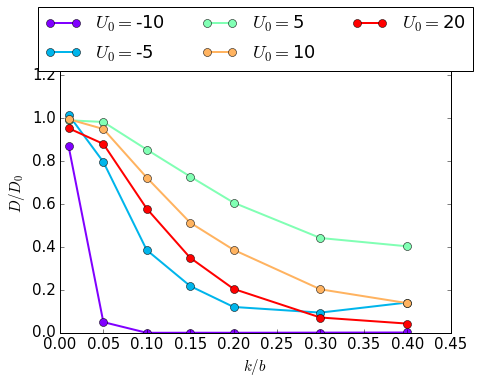

In [43]:
trigger ='ranRod/gamma'
p=0
uArr=['-10','-5','5','10','20']
a=0# This if fixed here, for no HI
ksdata=getDoverkdata(uArr,p,trigger)
plotdataArr(ksdata,r'k/b',lineArr=uArr,lineParam='$U_0 =$')

### Conclusion:
Interestingly, we do not see minima in the repulsive case anymore. Or, it may be shifted to the right (probably). To simulate with larger relative interaction range $k$, I would have to use a bigger system (or just accept that there is an unknown substantial error, due to the small system size.
The minimum in the attractive cases is strongly shifted to the right.

Since the minina are shifted to the right, I would also get different parameters for the comparison with Jason.
A larger relative interaction range k, leads to a smaller $b_{fit}$ to fit the simulation data to the experimental data, which in turn leads to a smaller $U_0$ needed to fit the data.
All in all, this might lead to better agreement between Jason and our data. 

NOTE: Maybe not, considering that the repulsive case seems to have a much stronger hindrance effect here.

___________________
___________________
___________________
___________________

# Test gamma distribution
$\Gamma(\alpha,\beta)$ where $\alpha$ and $\beta$ determine the shape of the distribution.
The mean of the distribution is $\alpha\cdot \beta$.
I look at cases where $\alpha\cdot \beta = b$, where $\bar{b}$ is the mesh size. 

In particular:
$\Gamma(10,1)$, $\Gamma(5,2)$ and $\Gamma(2.5,4)$

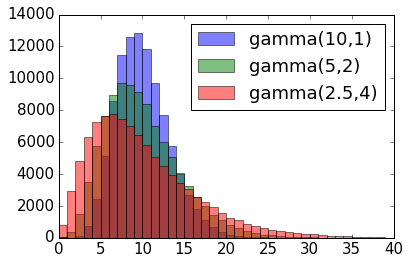

In [42]:
gammab1 = [np.random.gamma(10,1) for x in range(10**5)]
gammab2 = [np.random.gamma(5,2) for x in range(10**5)]
gammab4 = [np.random.gamma(2.5,4) for x in range(10**5)]
plt.hist(gammab1,bins=range(40),alpha=0.5,label="gamma(10,1)")
plt.hist(gammab2,bins=range(40),alpha=0.5,label="gamma(5,2)")
plt.hist(gammab4,bins=range(40),alpha=0.5,label="gamma(2.5,4)")
plt.legend()
plt.show()
bsP=[]
nzeros=0

In [ ]:
# TEST boost::gamma_distribution
gammafile = "/Users/jh/Documents/workspace-cpp/RanbSPS/Release/tmp_gamma.txt"
bs = []
with open(gammafile, 'r') as f:
    bs= f.readlines()
bs = [float(b.strip('\n')) for b in bs]
bs = np.asarray(bs)
plt.hist(bs,bins=range(40))

# Test if it is feasable to combine Ranb and ranRod
What pore size distribution do I obtain if I use the gamma distribution for the box size $b$ (Ranb) but place the rods randomly inside the simulation box (ranRod)?
In this example we use a gamma(2.5,4) distribution.

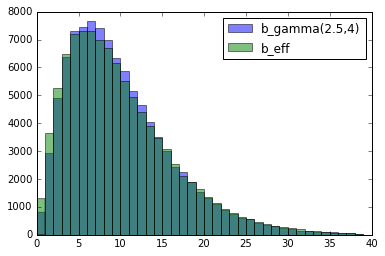

mean b_gamma = 10.0251656446
mean b_eff = 10.0251612939


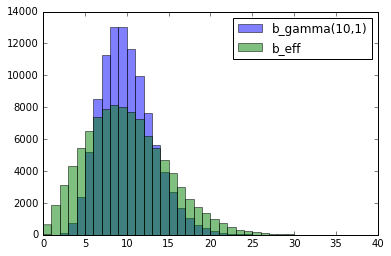

mean b_gamma = 10.0004869925
mean b_eff = 10.000466887


In [47]:
def gammab(a,b):
    return np.random.gamma(a,b)

alpha=2.5
beta=4
bs_gamma = []
bs_eff = []
b_prev = 0
rodpos_prev = 0
for i in range(100000):
    newb = gammab(alpha,beta)
    rodpos = np.random.uniform() * newb
    b_eff = b_prev - rodpos_prev + rodpos
    bs_gamma.append(newb)
    bs_eff.append(b_eff)
    b_prev = newb
    rodpos_prev = rodpos
plt.hist(bs_gamma,bins=range(40),alpha=0.5,label='b_gamma(2.5,4)')
plt.hist(bs_eff,bins=range(40),alpha=0.5,label='b_eff')
plt.legend()
plt.show()
print("mean b_gamma =",np.asarray(bs_gamma).mean())
print("mean b_eff =",np.asarray(bs_eff).mean())

alpha=10
beta=1
bs_gamma = []
bs_eff = []
b_prev = 0
rodpos_prev = 0
for i in range(100000):
    newb = gammab(alpha,beta)
    rodpos = np.random.uniform() * newb
    b_eff = b_prev - rodpos_prev + rodpos
    bs_gamma.append(newb)
    bs_eff.append(b_eff)
    b_prev = newb
    rodpos_prev = rodpos
plt.hist(bs_gamma,bins=range(40),alpha=0.5,label='b_gamma(10,1)')
plt.hist(bs_eff,bins=range(40),alpha=0.5,label='b_eff')
plt.legend()
plt.show()
print("mean b_gamma =",np.asarray(bs_gamma).mean())
print("mean b_eff =",np.asarray(bs_eff).mean())

In [25]:
def readTracerData(k,p,u,trigger='gamma'):
    tracerdata = []
    posfile = root+'/Documents/workspace-cpp/RanbSPS/Release/sim_data/'+trigger
    posfile += '/dt0.0005/t200/p'+str(p)+'/k'+str(k)+'/u'+str(u)+'/Coordinates/trajectory.txt'
    with open(posfile, 'r') as f:
        for i, line in enumerate(f):
            lines = line.split()
            tracerdata.append(lines)
    return  (np.asarray(tracerdata)).astype(float)

In [27]:
k='1.000';u=0;
p=10
tracerdat = readTracerData(k,p,u)

In [ ]:
t = tracerdat[:,0]
plt.plot(t,tracerdat[:,1],t,tracerdat[:,2],t,tracerdat[:,3])

________________
____________
____________
____________
____________
____________

# Test position shifting of ranRods
data obtained by printRodVec() function output, copied from terminal

In [64]:
data = [
    [[2,1] ,[0,-6.42889,-3.62594],[0,-2.18085,2.02793],[0,-1.65247,11.5036],[0,0,-10.0926],[0,8.56025,5.56824],[0,5.28747,19.2443],[0,11.4385,-6.5171],[0,10.3398,1.65464],[0,16.2594,18.9705]],
[[2,-1] ,[0,-1.92427,-0.0139103],[0,-6.42889,6.37406],[0,-2.18085,12.0279],[0,9.06804,-7.96832],[0,0,-0.0925607],[0,8.56025,15.5682],[0,13.3791,-4.91974],[0,11.4385,3.4829],[0,10.3398,11.6546]],
[[2,1] ,[0,-6.42889,-3.7185],[0,-2.18085,1.93537],[0,-2.94079,15.8612],[0,0,-10.1851],[0,8.56025,5.47568],[0,1.00261,18.6127],[0,11.4385,-6.60966],[0,10.3398,1.56208],[0,13.7299,19.5366]],
[[2,-1] ,[0,-1.16838,-2.05658],[0,-6.42889,6.2815],[0,-2.18085,11.9354],[0,2.25097,-4.21671],[0,0,-0.185121],[0,8.56025,15.4757],[0,12.1865,-3.36615],[0,11.4385,3.39034],[0,10.3398,11.5621]],
[[2,1] ,[0,-6.42889,-3.81106],[0,-2.18085,1.84281],[0,-6.77936,15.3303],[0,0,-10.2777],[0,8.56025,5.38311],[0,1.4761,12.8787],[0,11.4385,-6.70222],[0,10.3398,1.46952],[0,10.9434,14.6946]],
[[0,-1] ,[0,-6.42889,-3.81106],[0,-2.18085,1.84281],[0,-6.77936,15.3303],[0,0,-10.2777],[0,8.56025,5.38311],[0,1.4761,12.8787],[0,11.4385,-6.70222],[0,10.3398,1.46952],[0,10.9434,14.6946]],
[[0,1] ,[0,-6.42889,-3.81106],[0,-2.18085,1.84281],[0,-6.77936,15.3303],[0,0,-10.2777],[0,8.56025,5.38311],[0,1.4761,12.8787],[0,11.4385,-6.70222],[0,10.3398,1.46952],[0,10.9434,14.6946]],
[[0,-1] ,[0,-6.42889,-3.81106],[0,-2.18085,1.84281],[0,-6.77936,15.3303],[0,0,-10.2777],[0,8.56025,5.38311],[0,1.4761,12.8787],[0,11.4385,-6.70222],[0,10.3398,1.46952],[0,10.9434,14.6946]],
[[0,1] ,[0,-6.42889,-3.81106],[0,-2.18085,1.84281],[0,-6.77936,15.3303],[0,0,-10.2777],[0,8.56025,5.38311],[0,1.4761,12.8787],[0,11.4385,-6.70222],[0,10.3398,1.46952],[0,10.9434,14.6946]],
[[2,-1] ,[0,-1.80884,-2.2836],[0,-6.42889,6.18894],[0,-2.18085,11.8428],[0,8.82182,-5.64818],[0,0,-0.277682],[0,8.56025,15.3831],[0,11.1586,-0.190561],[0,11.4385,3.29778],[0,10.3398,11.4695]],
[[2,1] ,[0,-6.42889,-3.90362],[0,-2.18085,1.75025],[0,-1.64603,14.6611],[0,0,-10.3702],[0,8.56025,5.29055],[0,3.74962,13.6156],[0,11.4385,-6.79478],[0,10.3398,1.37696],[0,14.0902,16.2673]],
[[2,-1] ,[0,-6.64803,-8.60701],[0,-6.42889,6.09638],[0,-2.18085,11.7503],[0,0.923596,-7.83646],[0,0,-0.370243],[0,8.56025,15.2906],[0,14.7066,-2.19527],[0,11.4385,3.20522],[0,10.3398,11.377]],
[[2,1] ,[0,-6.42889,-3.99618],[0,-2.18085,1.65769],[0,-7.10147,11.2396],[0,0,-10.4628],[0,8.56025,5.19799],[0,6.36063,10.582],[0,11.4385,-6.88734],[0,10.3398,1.2844],[0,15.497,11.8813]],
[[2,-1] ,[0,-5.29668,-9.40485],[0,-6.42889,6.00382],[0,-2.18085,11.6577],[0,6.7518,-6.46347],[0,0,-0.462804],[0,8.56025,15.198],[0,14.1647,-8.70182],[0,11.4385,3.11266],[0,10.3398,11.2844]],
[[2,1] ,[0,-6.42889,-4.08874],[0,-2.18085,1.56513],[0,-7.1985,11.3448],[0,0,-10.5554],[0,8.56025,5.10543],[0,9.84541,10.4922],[0,11.4385,-6.9799],[0,10.3398,1.19184],[0,10.9116,18.8294]],
[[2,-1] ,[0,-2.62278,-6.65763],[0,-6.42889,5.91126],[0,-2.18085,11.5651],[0,7.23352,-5.59431],[0,0,-0.555364],[0,8.56025,15.1054],[0,13.4996,-0.813307],[0,11.4385,3.0201],[0,10.3398,11.1918]],
[[2,1] ,[0,-6.42889,-4.1813],[0,-2.18085,1.47257],[0,-0.0568928,34.1001],[0,0,-10.6479],[0,8.56025,5.01287],[0,2.87899,17.5698],[0,11.4385,-7.07247],[0,10.3398,1.09928],[0,13.8884,13.7852]]]

In [ ]:
axis = [x[0][0] for x in data]
exitmark = [x[0][1] for x in data]
positions = np.asarray([x[1:] for x in data])
print(positions[0])

In [ ]:
for i in range(0,5):
    ys = positions[i,:,1]
    zs = positions[i,:,2]
    plt.scatter(ys, zs)
    plt.scatter(positions[i+1,:,1], positions[i+1,:,2],c='r')
    plt.title('axis: '+str(axis[i])+'   exitmark: '+str(exitmark[i]))
    plt.xlabel('y')
    plt.ylabel('z')
    #plt.xlim([-10,20])
    #plt.ylim([-10,20])
    plt.show()

In [4]:
Vcyl = lambda a, b: np.pi*b*(a/2.)**2
def phi(a,b=10): return (3*Vcyl(a,b) - 8 * np.sqrt(2) * (a/2.)**3)/b**3
def alpha(p, a):
    return phi(a,b=1)*((a+p)/a)**2

def Ogston(p, a):
    return np.exp( -(a+p)/a * np.sqrt(phi(a,b=1)))

def Johnson(p, a):
    return np.exp(-0.84 * alpha( p, a)**1.09)

def Tsai(p, a):
    return (1 + 2/3 *alpha(p, a))**-1


# For Alexa in Dextran values in nanometers
m_a=162*1.66
aexp=0.39
pexp=1.9
aop = aexp/pexp

def Cpoly(a,aexp=0.4):
    "m_a is the monomer weight, a the monomer diameter in relative units"
    Vmonomer_exp = Vcyl(aexp,aexp)
    # nmonomerPerCell = Vpolymer/Vmonomer with phi = Vpolymer/Vcell
    return m_a * phi(a,b=1) / Vmonomer_exp
atest=0.05



def CpolyFrompNoHI(p_s):
    return (p_s**3 *m_a / (aexp*(pexp+aexp)**3)) * (3 * (pexp+aexp)/p_s - 2 * aexp)
print(CpolyFrompNoHI(0.9))#WORKS!

#Extract simulation data 
idata=2
ranRodData = u0data[idata]
print("ranRod Trigger: ",triggerArr[idata])
psRR = ranRodData[:,0]
dd0sRR = ranRodData[:,1]/6.
SPSData = u0data[0]
psSPS = SPSData[:,0]
dd0sSPS = SPSData[:,1]/6.

avals = np.arange(0.0001,0.27,0.001)
Cvals = Cpoly(avals)

#Plot it all together
plt.figure(figsize=(7,5))
colors=cm.rainbow(np.linspace(0,1,5))
lst=['-','--',':']
functions=[Ogston,Johnson,Tsai]
for i,f in enumerate(functions):
    #plt.plot(phivals, f(avals/aop , avals),label=f.__name__)
    dd0vals =  f(avals/aop , avals)
    plt.plot(Cvals,dd0vals,label=f.__name__,linestyle=lst[i],c='0.3' )
plt.plot(CpolyFrompNoHI(psRR),dd0sRR,'ro',label='ranRod fix #')
plt.plot(CpolyFrompNoHI(psSPS),dd0sSPS,'g^',label='fixed distance')
plt.xlabel(r'$C_{poly}$')
#plt.xlabel(r'$\phi$')
plt.ylabel(r'$D/D_0$')
plt.xlim([0,600])
plt.legend()
plt.show()

286.86755537231954


NameError: name 'u0data' is not defined